<a href="https://colab.research.google.com/github/shamiim611/zindi_practice_challenges/blob/main/animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import zipfile
import random

In [ ]:
%%capture
!pip install torchinfo

In [ ]:
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
import sklearn.model_selection
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,roc_auc_score
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR

In [ ]:
# import the training module
sys.path.append('/content/drive/MyDrive/Colab Notebooks/data_animal_classification')
import training

In [ ]:
test_path ="/content/drive/MyDrive/Colab Notebooks/data_animal_classification/test.zip"
train_elephant ="/content/drive/MyDrive/Colab Notebooks/data_animal_classification/train_elephants.zip"
train_zebra ="/content/drive/MyDrive/Colab Notebooks/data_animal_classification/train_zebras.zip"
#inspect zip file contents
with zipfile.ZipFile(test_path, 'r') as test_zip:
    test_files =test_zip.namelist()
    print(f"Number of images in test.zip: {len(test_files)}")
with zipfile.ZipFile(train_elephant, 'r') as elephant_zip:
    elephant_files = elephant_zip.namelist()
    print(f"Number of  labelled elephant images: {len(elephant_files)}")
with zipfile.ZipFile(train_zebra, 'r') as zebra_zip:
    zebra_files = zebra_zip.namelist()
    print(f"Number of  labelled zebra images: {len(zebra_files)}")

Number of images in test.zip: 12003
Number of  labelled elephant images: 14004
Number of  labelled zebra images: 14004


In [ ]:
data_dir ="/content/drive/MyDrive/Colab Notebooks/data_animal_classification"
# Subdirectories
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
#create directories
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
#extract test images
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if "__MACOSX" in member or member.startswith("._"):
            continue  # skip metadata files
        zip_ref.extract(member, test_dir)

In [ ]:
#extract elephant images
elephant_class_dir = os.path.join(train_dir, "elephant")
os.makedirs(elephant_class_dir, exist_ok=True)

with zipfile.ZipFile(train_elephant, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if "__MACOSX" in member or member.startswith("._"):
            continue  # skip metadata files
        zip_ref.extract(member, elephant_class_dir)

In [ ]:
#extract zebra images
zebra_class_dir = os.path.join(train_dir, "zebra")
os.makedirs(zebra_class_dir, exist_ok=True)

with zipfile.ZipFile(train_zebra, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if "__MACOSX" in member or member.startswith("._"):
            continue  # skip metadata files
        zip_ref.extract(member, zebra_class_dir)

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


start working with the data

In [ ]:
data_dir ="/content/drive/MyDrive/Colab Notebooks/data_animal_classification"
# Subdirectories
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [ ]:
#dataset
train_dataset = datasets.ImageFolder(root = train_dir)
classes = train_dataset.classes
print(classes)
print(f"number of images in the train dataset: {len(train_dataset)}")
print(f"image size: {(train_dataset[0][0]).size}")
print(f"image mode: {(train_dataset[0][0]).mode}")
# how many of each class do we have
c = Counter(x[1] for x in tqdm(train_dataset))
class_to_index = train_dataset.class_to_idx
counts = pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})
counts

['elephant', 'zebra']
number of images in the train dataset: 13999
image size: (330, 330)
image mode: RGB


  0%|          | 0/13999 [00:00<?, ?it/s]

elephant    7000
zebra       6999
dtype: int64

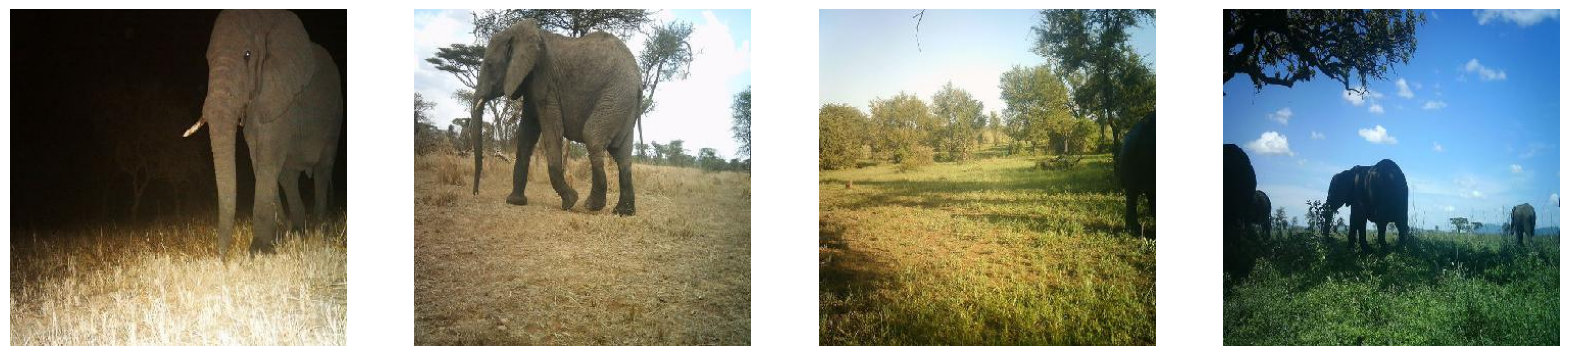

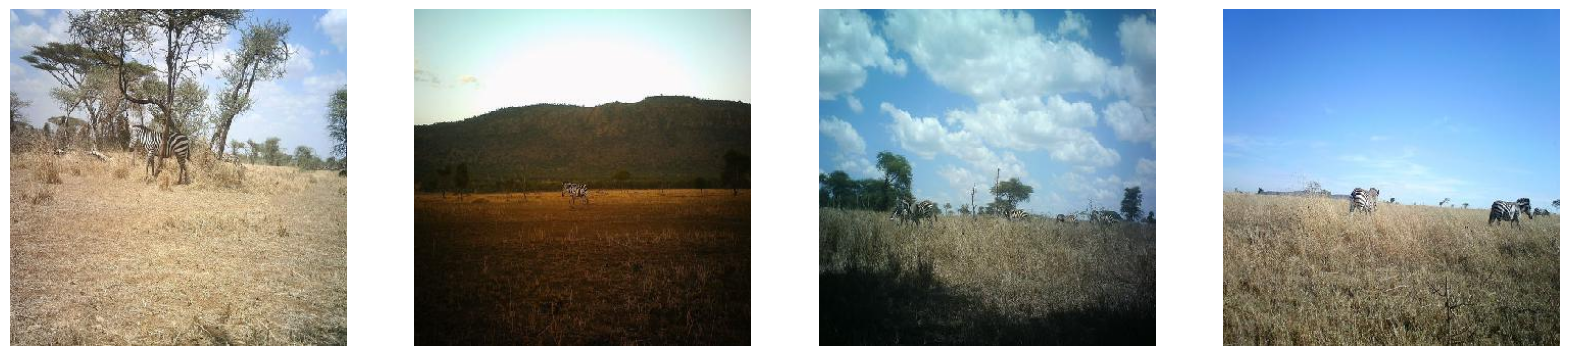

In [ ]:
#let us sample 4 images of each class
def sample_images(data_path, class_name):
  # explore a few images
  class_dir = os.path.join(data_path, class_name)
  class_list = os.listdir(class_dir)
  # Pick four random images
  images_sample = random.sample(class_list, 4)

  # Plot them
  plt.figure(figsize=(20, 20))
  for i in range(4):
    img_loc = os.path.join(class_dir, images_sample[i])
    img = PIL.Image.open(img_loc)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
sample_images(elephant_class_dir,'train_elephants')
sample_images(zebra_class_dir,'train_zebras')

transform data

In [ ]:
# ensure all images are of the same mode
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [ ]:
#basic transformation pipeline
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [ ]:
#create a dataset loader
batch_size = 32
dataset = datasets.ImageFolder(root = train_dir,transform =transform_basic)
dataset_loader =DataLoader(dataset= dataset,batch_size= batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [ ]:
#get mean and std
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std
#print the mean and std
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/438 [00:00<?, ?it/s]

Mean: tensor([0.4248, 0.4612, 0.4365])
Standard deviation: tensor([0.2802, 0.2940, 0.3350])


In [ ]:
mean = [0.4248, 0.4612, 0.4365]
std = [0.2802, 0.2940, 0.3350]
#normalized transformation pipeline
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)
#make a new normalized dataset
norm_dataset = datasets.ImageFolder(root = train_dir,transform =transform_norm)
norm_loader =DataLoader(dataset= norm_dataset,batch_size= batch_size)

transfer learning

In [ ]:
#get resnet model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
#get the summary of our model
#shape of the first batch
test_batch = next(iter(norm_loader))[0]
batch_shape = test_batch.shape

# Create the model summary
summary(model,batch_shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [ ]:
# freeze weights
for params in model.parameters():
    params.requires_grad = False

In [ ]:
# Move the model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

transform the model to our task

In [ ]:
in_features = model.fc.in_features
print(f"in features:{in_features}")

in features:2048


In [ ]:
#build our classifier
classifier = torch.nn.Sequential()
classification_layer = torch.nn.Linear( in_features= in_features, out_features= 256)
# Add the layer to our classifier
classifier.append(classification_layer)
classifier.append(torch.nn.ReLU())
classifier.append(torch.nn.Dropout())
output_layer = torch.nn.Linear( in_features= 256, out_features= 2)

# Add the layer to our classifier
classifier.append(output_layer)
model.fc = classifier

training with k-fold

In [ ]:
#k-fold
k = 5
kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
#define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
#we'll need to reset the model when we change which fold is the validation set.
#Otherwise the model will have seen that data, which means it's not a good validation set!
#function to reset parameters after each fold
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

train

In [ ]:
import training
from training import train, predict,score, train_epoch

In [ ]:
num_epochs = 6
training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(norm_dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(norm_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(norm_dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)
    # Move the model to device
    model.to(device)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=num_epochs,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.16
    Validation loss: 0.08
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.09
    Validation loss: 0.06
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.06
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.06
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.05
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.05
    Validation loss: 0.04
    Validation accuracy: 0.98



*****Fold 2*****


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.15
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.08
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.06
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.06
    Validation loss: 0.04
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.04
    Validation loss: 0.04
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.04
    Validation loss: 0.04
    Validation accuracy: 0.98



*****Fold 3*****


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.14
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.08
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.06
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.05
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.05
    Validation loss: 0.04
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.04
    Validation loss: 0.05
    Validation accuracy: 0.98



*****Fold 4*****


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.15
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.08
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.06
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.05
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.04
    Validation loss: 0.06
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.04
    Validation loss: 0.05
    Validation accuracy: 0.98



*****Fold 5*****


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.14
    Validation loss: 0.07
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.07
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.06
    Validation loss: 0.05
    Validation accuracy: 0.97


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.05
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.04
    Validation loss: 0.05
    Validation accuracy: 0.98


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.04
    Validation loss: 0.04
    Validation accuracy: 0.98





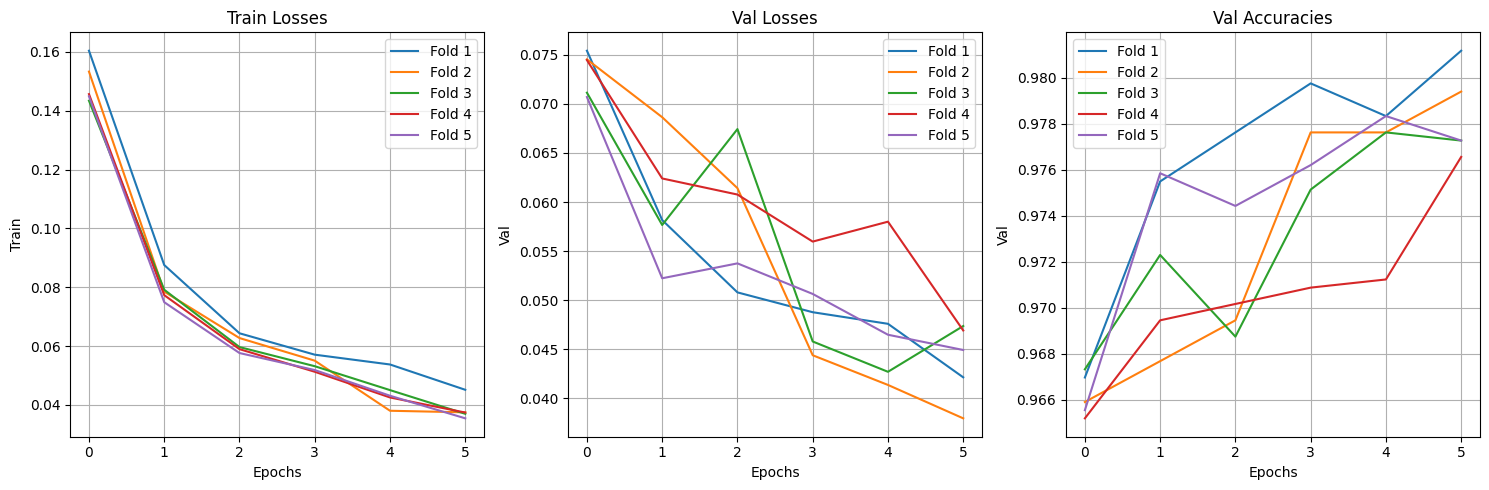

In [ ]:
#pl0t the metrics
def plot_metrics(data):
    metrics = ['train_losses', 'val_losses', 'val_accuracies']
    num_metrics = len(metrics)

    plt.figure(figsize=(15, 5))

    for idx, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, idx + 1)
        for fold in data.keys():
            plt.plot(data[fold][metric], label=f"Fold {fold}")
        plt.title(metric.replace('_', ' ').title())
        plt.xlabel("Epochs")
        plt.ylabel(metric.split('_')[0].capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_metrics(training_records)

we consider the average of the values for each fold for the last eopch

In [ ]:
#get the last values(last epoch)
def fold_average(data, metric):
  for fold in data.keys():
    return np.mean(data[fold][metric][-1])
for metric in training_records[1].keys():
  print(f"average_{metric}:{(fold_average(training_records, metric)):.3f}")

average_train_losses:0.045
average_val_losses:0.042
average_val_accuracies:0.981


confusion matrix

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

<Figure size 1000x800 with 0 Axes>

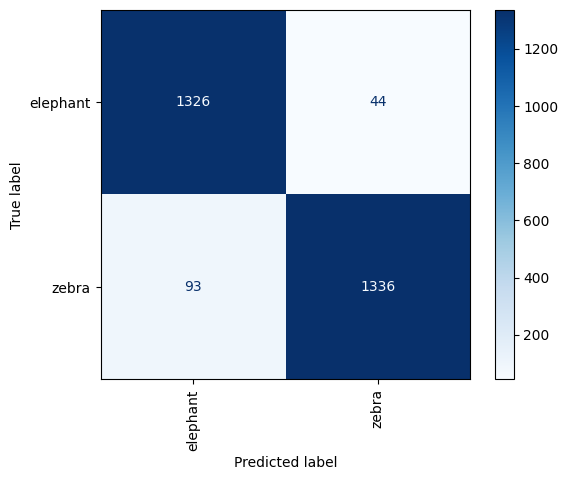

In [ ]:
# bse for each fold we were resetting parameters
#currently the model is trained on the last fold(fold5)
# get the validation set
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# use the predict function from the training module
probabilities = predict(model, val_loader, device=device)
predictions = torch.argmax(probabilities, dim=1)
#print(probabilities.size())
#pull tragets into a list
targets = []
for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())
#confusion matrix
cm = confusion_matrix(targets, predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

In [ ]:
#roc auc score on validation set
roc_auc_score(targets, predictions.cpu())

np.float64(0.9514013679107945)

callbacks, learning rate scheduling, and checkpointing

In [ ]:
#learning rate scheduling
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [ ]:
#early stopping
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter >= 5:
        stop = True

    return counter, stop

In [ ]:
#checkpointing
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

train set and validation set

In [ ]:
#split
train_dataset, val_dataset = random_split(norm_dataset,[0.8,0.2])
batch_size = 32
# create loaders
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle= True)

val_loader = DataLoader(val_dataset,batch_size = batch_size,shuffle = False)

we trained for 8 epochs yesterday
today we load the save model from the checkpoint
make sure it is moved to the correct device and the optimizer tensors

In [ ]:
#resume training from checkpoint
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/data_animal_classification/model/LR_model.pth",map_location= device)
model.load_state_dict(checkpoint['model_state_dict'])

# If you plan to resume training:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Move optimizer tensors to correct device
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [ ]:
start_epoch = 9
#modify the train function to include callbacks, early stopping and checkpointing
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0
    # put model to gpu
    model.to(device)

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(start_epoch, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [ ]:
#create model directory to save the model from checkpointing
model_dir = os.path.join(data_dir, "model")
os.makedirs(model_dir, exist_ok=True)
#checkpointing path
checkpoint_path = os.path.join(model_dir, "LR_model.pth")

In [ ]:
epochs_to_train = 50

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path,
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]



Starting epoch 9/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.0162
Training accuracy: 99.4821%
Validation loss: 0.0131
Validation accuracy: 99.0412%
Checkpoint saved with validation loss 0.0131


Starting epoch 10/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.0154
Training accuracy: 99.5536%
Validation loss: 0.0145
Validation accuracy: 98.9347%


Starting epoch 11/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.0143
Training accuracy: 99.5625%
Validation loss: 0.0133
Validation accuracy: 99.0412%


Starting epoch 12/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.0135
Training accuracy: 99.6071%
Validation loss: 0.0127
Validation accuracy: 98.9702%
Checkpoint saved with validation loss 0.0127


Starting epoch 13/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.0134
Training accuracy: 99.5982%
Validation loss: 0.0125
Validation accuracy: 99.0057%
Checkpoint saved with validation loss 0.0125


Starting epoch 14/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.0131
Training accuracy: 99.5893%
Validation loss: 0.0133
Validation accuracy: 98.8991%


Starting epoch 15/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.0133
Training accuracy: 99.5982%
Validation loss: 0.0126
Validation accuracy: 99.0767%


Starting epoch 16/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.0135
Training accuracy: 99.6071%
Validation loss: 0.0131
Validation accuracy: 99.0767%


Starting epoch 17/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.0134
Training accuracy: 99.5893%
Validation loss: 0.0141
Validation accuracy: 98.8991%


Starting epoch 18/50


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/350 [00:00<?, ?it/s]

Scoring:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 18
Training loss: 0.0130
Training accuracy: 99.6250%
Validation loss: 0.0135
Validation accuracy: 98.9702%
Early stopping triggered after 18 epochs


In [ ]:
#now let us the best model saved with checkpointing
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/data_animal_classification/model/LR_model.pth",map_location= device)

# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
train_dataset = datasets.ImageFolder(root = train_dir)
classes = train_dataset.classes
classes

['elephant', 'zebra']

Predicting:   0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

<Figure size 1000x800 with 0 Axes>

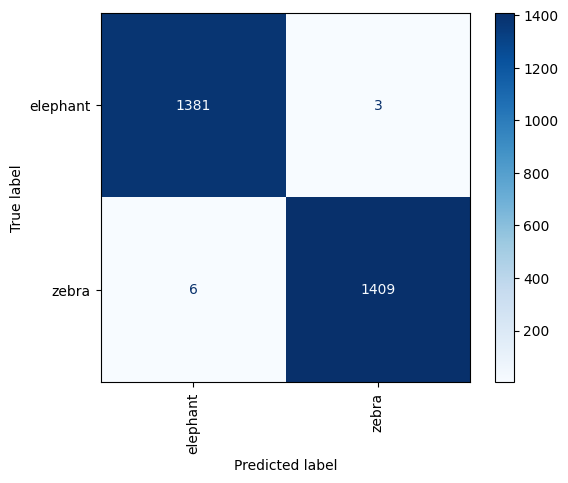

In [ ]:

# use the predict function from the training module
probabilities = predict(model, val_loader, device=device)
predictions = torch.argmax(probabilities, dim=1)
#print(probabilities.size())
#pull tragets into a list
targets = []
for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())
#confusion matrix
cm = confusion_matrix(targets, predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

In [ ]:
#roc auc score on validation set
roc_auc_score(targets, predictions.cpu())

np.float64(0.996796043628342)

test data

In [ ]:
test_dataset = datasets.ImageFolder(root = test_dir,transform =transform_norm)
test_loader =DataLoader(dataset= test_dataset,batch_size= batch_size)
test_prob = predict(model, test_loader, device=device)
test_pred = torch.argmax(test_prob, dim=1)
print(test_prob.size())

Predicting:   0%|          | 0/188 [00:00<?, ?it/s]

torch.Size([5999, 2])


In [ ]:
test_images_dir = os.path.join(test_dir,'test')
len(os.listdir(test_images_dir))

6000

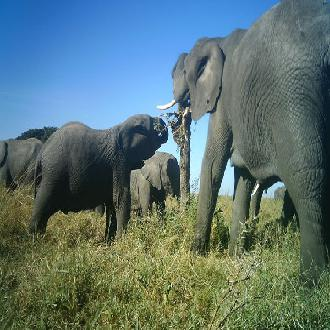

In [ ]:
image = PIL.Image.open("/content/drive/MyDrive/Colab Notebooks/data_animal_classification/test/test/ASG0014ip3_0.jpeg")
image

In [ ]:
test_images_dir = os.path.join(test_dir, 'test')
small_dfs = []

model.eval()

for image_path in tqdm(os.listdir(test_images_dir), desc="Predicting on test set"):
    # skip non image files
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')):
        continue
    file_path = os.path.join(test_images_dir, image_path)
    image = PIL.Image.open(file_path)

    # Transform image
    transformed = transform_norm(image)
    #change it to 4d since our model is expecting a batch
    # Add batch dimension and move to device
    image_to_device = transformed.unsqueeze(0).to(device)

    with torch.no_grad():
        model_output = model(image_to_device)
        prob = torch.nn.functional.softmax(model_output, dim=1)
        pred = torch.argmax(prob, dim=1).item()  # use .item() to get scalar

    # Create a dataframe row
    sub_df = pd.DataFrame([[image_path, pred]], columns=["id", "label"])
    small_dfs.append(sub_df)

# Concatenate all results
df = pd.concat(small_dfs, axis=0)
df = df.sort_values("id").reset_index(drop=True)
print(df.head())

Predicting on test set:   0%|          | 0/6000 [00:00<?, ?it/s]

                  id  label
0  ASG0014ip3_0.jpeg      0
1  ASG0014ip3_1.jpeg      0
2  ASG0014ip5_1.jpeg      0
3  ASG0014ip9_0.jpeg      0
4  ASG0014ipc_0.jpeg      0


In [ ]:
df.to_csv('submission.csv')